# Prompt token/word/char counts

Load the first prompt from several prompt JSON files and report:
- n characters
- n words (whitespace split)
- n tokens (simple non-whitespace tokenization using regex)

The notebook auto-discovers files in the `prompts/` directory and prints which files were used.

In [ ]:
import json
import re
from pathlib import Path
import pandas as pd
from IPython.display import display

from transformers import AutoTokenizer
from transformers import pipeline

from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

# --- Tokenizer (LLaMA-family) ---

# If you're using a different LLaMA 7B variant, swap this string to the matching tokenizer repo.

def count_tokens(text: str) -> int:
    """LLaMA-style token count via HF tokenizer (subword tokens, not whitespace runs)."""
    return len(tokenizer.encode(text, add_special_tokens=False))

def _find_first_string_in_obj(obj):
    if isinstance(obj, str):
        return obj
    if isinstance(obj, list) and obj:
        for v in obj:
            s = _find_first_string_in_obj(v)
            if s:
                return s
        return None
    if isinstance(obj, dict) and obj:
        for k in ('instructions', 'instruction', 'prompt', 'text', 'content', 'body', 'question'):
            if k in obj and isinstance(obj[k], str) and obj[k].strip():
                return obj[k]
        for v in obj.values():
            s = _find_first_string_in_obj(v)
            if s:
                return s
    return None

def load_first_prompt(path: Path) -> tuple[str, str]:
    if not path.exists():
        return ('', 'missing')
    raw = path.read_text(encoding='utf-8')
    try:
        data = json.loads(raw)
    except Exception:
        return (raw, 'raw')

    if isinstance(data, list) and len(data) > 0:
        first = data[0]
        s = _find_first_string_in_obj(first)
        if s:
            return (s, 'direct')
        s = _find_first_string_in_obj(data)
        if s:
            return (s, 'direct')
        return (json.dumps(first), 'fallback_json')

    if isinstance(data, dict):
        s = _find_first_string_in_obj(data)
        if s:
            return (s, 'direct')
        return (json.dumps(data), 'fallback_json')

    if isinstance(data, str):
        return (data, 'direct')

    return (raw, 'raw')

# Auto-discover files in prompts/ (handle common variants)
repo_root = Path('/Users/rsalvi/Desktop/mccviahat')
prompt_dir = repo_root / 'prompts'
expected_bases = ['training_neutral', 'training_emotional', 'Perm_test_e', 'Perm_test_n']
found_files = []
all_jsons = sorted(prompt_dir.glob('*.json')) if prompt_dir.exists() else []
for base in expected_bases:
    match = None
    for p in all_jsons:
        if p.stem.lower() == base.lower():
            match = p
            break
    if match is None:
        for p in all_jsons:
            if p.stem.lower().startswith(base.lower()):
                match = p
                break
    if match is None:
        p_try = prompt_dir / (base.capitalize() + '.json')
        if p_try.exists():
            match = p_try
    if match is None:
        match = prompt_dir / f"{base}.json"
    found_files.append(match)

print('Prompt files used (in order):')
for p in found_files:
    print(' -', p)

rows = []
for p in found_files:
    row = {'file': str(p)}
    try:
        text, method = load_first_prompt(p)
        if text is None:
            text = ''
        n_chars = len(text)
        n_words = len(text.split())
        n_tokens = count_tokens(text)
        row.update({
            'n_chars': n_chars,
            'n_words': n_words,
            'n_tokens': n_tokens,
            'method': method,
            'preview': text[:300]
        })
    except Exception as e:
        row.update({
            'n_chars': None,
            'n_words': None,
            'n_tokens': None,
            'method': 'error',
            'preview': f'ERROR: {e}'
        })
    rows.append(row)

cols = ['file', 'method', 'n_chars', 'n_words', 'n_tokens', 'preview']
df = pd.DataFrame(rows)[cols]
df.index = range(1, len(df) + 1)

display(df)

# Save to both repo absolute path and current working dir, and print status
out_csv_repo = repo_root / 'analysis' / 'token_counts.csv'
out_csv_cwd = Path.cwd() / 'analysis' / 'token_counts.csv'
saved_paths = []
for out_csv in (out_csv_repo, out_csv_cwd):
    try:
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(out_csv, index=False)
        saved_paths.append(out_csv)
    except Exception as e:
        print(f"Could not save to {out_csv}: {e}")

if saved_paths:
    print('Saved counts to:')
    for p in saved_paths:
        try:
            stat = p.stat()
            print(f" - {p}  ({stat.st_size} bytes)")
        except Exception:
            print(f" - {p}  (saved)")
else:
    print('No CSVs could be saved.')

Prompt files used (in order):
 - /Users/rsalvi/Desktop/mccviahat/prompts/Perm_e.json
 - /Users/rsalvi/Desktop/mccviahat/prompts/Perm_training_n.json
 - /Users/rsalvi/Desktop/mccviahat/prompts/Perm_test_e.json
 - /Users/rsalvi/Desktop/mccviahat/prompts/Perm_test_n.json


,file,method,n_chars,n_words,n_tokens,preview
1,/Users/rsalvi/Desktop/mccviahat/prompts/Perm_e...,direct,7944,1354,2166,It's around noon on a hot day in April. You a...
2,/Users/rsalvi/Desktop/mccviahat/prompts/Perm_t...,direct,9612,1548,2155,Begin the repair by carefully opening the door...
3,/Users/rsalvi/Desktop/mccviahat/prompts/Perm_t...,direct,7405,1213,2156,"You're alone in a thick, foggy forest as night..."
4,/Users/rsalvi/Desktop/mccviahat/prompts/Perm_t...,direct,8891,1447,2141,"On a completely ordinary Thursday morning, jus..."


Saved counts to:
 - /Users/rsalvi/Desktop/mccviahat/analysis/token_counts.csv  (1578 bytes)
 - /Users/rsalvi/Desktop/mccviahat/analysis/analysis/token_counts.csv  (1578 bytes)


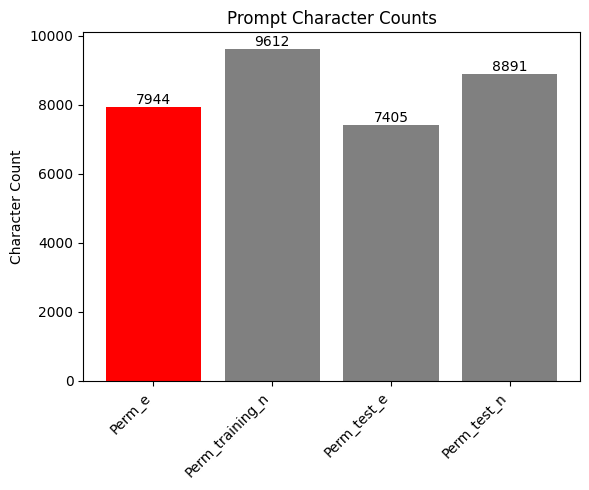

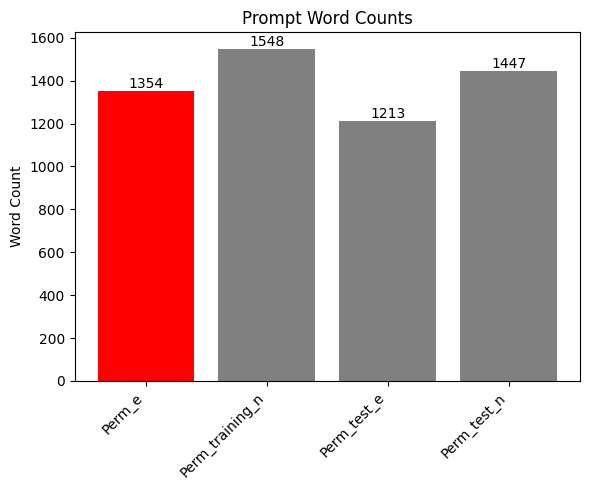

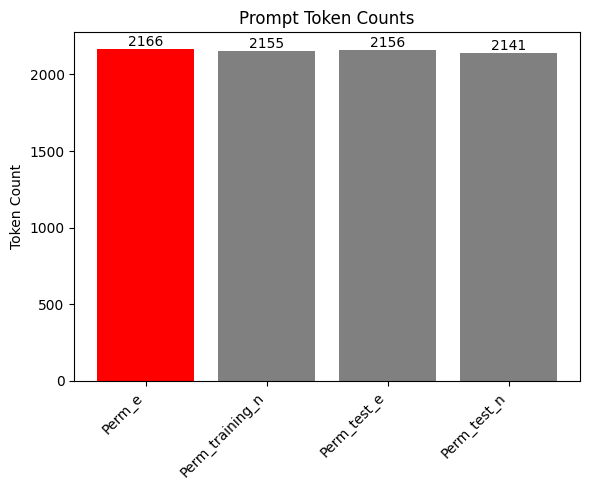

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# Ensure numeric columns
df_plot = df.copy()
for c in ('n_chars','n_words','n_tokens'):
    df_plot[c] = pd.to_numeric(df_plot[c], errors='coerce').fillna(0).astype(int)

labels = [Path(f).stem for f in df_plot['file']]
x = np.arange(len(labels))

# ---- Color mapping ----
def get_color(name):
    name = name.lower()
    if name.startswith('perm_e'):
        return 'red'
    elif name.startswith('perm_n'):
        return 'blue'
    elif name.startswith('test'):
        return 'green'
    else:
        return 'gray'

colors = [get_color(label) for label in labels]

# ---- Add value labels ----
def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{int(height)}',
            ha='center',
            va='bottom'
        )

# ---------- 1) Characters ----------
fig1, ax1 = plt.subplots(figsize=(max(6, len(labels)*1.5), 5))
bars1 = ax1.bar(x, df_plot['n_chars'], color=colors)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_ylabel('Character Count')
ax1.set_title('Prompt Character Counts')
add_labels(ax1, bars1)
plt.tight_layout()
plt.show()

# ---------- 2) Words ----------
fig2, ax2 = plt.subplots(figsize=(max(6, len(labels)*1.5), 5))
bars2 = ax2.bar(x, df_plot['n_words'], color=colors)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylabel('Word Count')
ax2.set_title('Prompt Word Counts')
add_labels(ax2, bars2)
plt.tight_layout()
plt.show()

# ---------- 3) Tokens ----------
fig3, ax3 = plt.subplots(figsize=(max(6, len(labels)*1.5), 5))
bars3 = ax3.bar(x, df_plot['n_tokens'], color=colors)
ax3.set_xticks(x)
ax3.set_xticklabels(labels, rotation=45, ha='right')
ax3.set_ylabel('Token Count')
ax3.set_title('Prompt Token Counts')
add_labels(ax3, bars3)
plt.tight_layout()
plt.show()


